In [1]:
#Package import

from sentence_transformers import SentenceTransformer
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import metrics
import matplotlib.pyplot as plt
from tensorflow_addons.optimizers import AdamW

2023-02-17 10:36:43.017959: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-17 10:36:58.020463: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /apps/spack/bell/apps/gcc/9.3.0-gcc-4.8.5-z2ug7z7/lib64:/apps/spack/bell/apps/gcc/9.3.0-gcc-4.8.5-z2ug7z7/lib:/apps/spack/bell/apps/zlib/1.2.11-gcc-9.3.0-7x3gabj/lib:/apps/spack/bell/apps/mpc/1.1.0-gcc-4.8.5-wwn2jff/lib:/apps/spack/bell/apps/mpfr/3.1.6-gcc-4.8.5-xyisskj/lib:/apps/spack/bell/apps/gmp/6.1.2-gcc-4.8.5-6bsovvk/lib:/apps/spack/bell/apps/anaconda/2020.02-py37-gcc-4.8.5-u747gsx/lib
2023-0

In [2]:
#importing Labse model from hugging face

labse = SentenceTransformer('sentence-transformers/LaBSE')

data=pd.read_csv('data_2.csv')

print(data.head(5))
print(data.tail(5))

                                                text complexity
0  Karabo Ngidi, a lawyer with the centre, said: ...     simple
1  The age of the big British summer music festiv...     simple
2  The town is here because of the mine, says Dep...     simple
3  We want to find a few photos to put with the b...     simple
4    Inzozi Nziza was opened by Odile Gakire Katese.     simple
                                                    text   complexity
14975  Si kwamba twatosha sisi wenyewe kufikiri neno ...  complicated
14976  Mnataka vipi? Nije kwenu na fimbo, au nije kat...  complicated
14977  Maana, ndugu, mnakumbuka taabu yetu na masumbu...  complicated
14978  Na usifiwe utukufu wa neema yake, ambayo ametu...  complicated
14979  Kwa sababu Bwana mwenyewe atashuka kutoka mbin...  complicated


In [3]:
#binary encoding for target field
data.loc[data['complexity']=='simple','complexity']=0
data.loc[data['complexity']=='complicated','complexity']=1

print(data.head(5))
print(data.tail(5))

                                                text complexity
0  Karabo Ngidi, a lawyer with the centre, said: ...          0
1  The age of the big British summer music festiv...          0
2  The town is here because of the mine, says Dep...          0
3  We want to find a few photos to put with the b...          0
4    Inzozi Nziza was opened by Odile Gakire Katese.          0
                                                    text complexity
14975  Si kwamba twatosha sisi wenyewe kufikiri neno ...          1
14976  Mnataka vipi? Nije kwenu na fimbo, au nije kat...          1
14977  Maana, ndugu, mnakumbuka taabu yetu na masumbu...          1
14978  Na usifiwe utukufu wa neema yake, ambayo ametu...          1
14979  Kwa sababu Bwana mwenyewe atashuka kutoka mbin...          1


In [4]:
#Test and traning split
def test_train(dataset,val):

    label_all=np.array(dataset.complexity.values,dtype=np.float16)
    
    df_idx, test_idx = train_test_split(
        np.arange(len(label_all)),
        test_size = val,
        shuffle = True,
        stratify = label_all)
    
    
    d1=dataset.loc[dataset.index.isin(df_idx)]
    d2=dataset.loc[dataset.index.isin(test_idx)]
    
    d1.reset_index(drop=True,inplace=True)
    d2.reset_index(drop=True,inplace=True)
    
    return d1,d2

In [5]:
#use second parameter to specify split ratio (corrresponds to proportion of test data)

df,df_test=test_train(data,0.0001)

print("Training data:",df.shape)
print("Testing data:",df_test.shape)

Training data: (14978, 2)
Testing data: (2, 2)


In [6]:
#test and validation split along with encoding

def train_val(dataset,val):

    labels=np.array(dataset.complexity.values,dtype=np.float16)
    
    if val != 0:
        train_idx, val_idx = train_test_split(
            np.arange(len(labels)),
            test_size = val,
            shuffle = True,
            stratify = labels)
    else:
        train_idx=np.array([*range(len(dataset))])
        val_idx=[]
    
    texts=dataset.text.values

    t1=texts[train_idx]
    t2=labels[train_idx]
    
    t3=texts[val_idx]
    t4=labels[val_idx]
    
    t1=np.array([labse.encode(i) for i in t1])
    
    if val != 0:
        t3=np.array([labse.encode(i) for i in t3])
    
    return t1, t2, t3, t4

In [8]:
#use second parameter to specify split ratio (corrresponds to proportion of validation data).

train_x,train_y,val_x,val_y=train_val(df,0.1)

In [9]:
#viewing training data

print("training data:",train_x.shape)
train_x[0:3]

training data: (13480, 768)


array([[-0.04574548, -0.01605996, -0.0803916 , ..., -0.00806262,
         0.03687363, -0.02361694],
       [ 0.01132295, -0.02773057, -0.01190652, ..., -0.05851452,
         0.01272868, -0.0266791 ],
       [ 0.02192913,  0.0288132 ,  0.02316691, ..., -0.01965865,
        -0.05077596,  0.06755242]], dtype=float32)

In [10]:
#viewing training labels

print("training labels:",train_y.shape)
train_y[0:3]

training labels: (13480,)


array([1., 0., 1.], dtype=float16)

In [11]:
#viewing validation data

print("validation data:",val_x.shape)
val_x[0:3]

validation data: (1498, 768)


array([[-0.05001695, -0.00957072, -0.04676677, ...,  0.01846896,
         0.0058149 ,  0.01822535],
       [ 0.00958925, -0.08302104, -0.06851174, ...,  0.00134011,
         0.02782863,  0.01136474],
       [-0.02794001, -0.01198375, -0.02823161, ..., -0.02705377,
         0.00120737, -0.00249543]], dtype=float32)

In [12]:
#viewing validation labels

print("validation labels:",val_y.shape)
val_y[0:3]

validation labels: (1498,)


array([0., 1., 0.], dtype=float16)

In [13]:
#model declaration

model = keras.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(768,)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation='relu')) 
model.add(layers.Dense(1, activation='sigmoid'))

print(model.summary())

#optimizer


optimizer=keras.optimizers.Adam(learning_rate=0.0001)

#compile model
model.compile(optimizer=optimizer,loss=tf.losses.BinaryCrossentropy(),metrics=['accuracy'])

#model training
history = model.fit(train_x,train_y,validation_data=(val_x,val_y),epochs=10, batch_size=16)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               98432     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 108,801
Trainable params: 108,801
Non-trai

2023-02-17 11:32:18.538048: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /apps/spack/bell/apps/gcc/9.3.0-gcc-4.8.5-z2ug7z7/lib64:/apps/spack/bell/apps/gcc/9.3.0-gcc-4.8.5-z2ug7z7/lib:/apps/spack/bell/apps/zlib/1.2.11-gcc-9.3.0-7x3gabj/lib:/apps/spack/bell/apps/mpc/1.1.0-gcc-4.8.5-wwn2jff/lib:/apps/spack/bell/apps/mpfr/3.1.6-gcc-4.8.5-xyisskj/lib:/apps/spack/bell/apps/gmp/6.1.2-gcc-4.8.5-6bsovvk/lib:/apps/spack/bell/apps/anaconda/2020.02-py37-gcc-4.8.5-u747gsx/lib
2023-02-17 11:32:18.538079: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-17 11:32:18.538101: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bell-a150.rcac.purdue.edu): /proc/driver/nvidia/version do

None
Epoch 1/10
843/843 [==============================] - 2s 2ms/step - loss: 0.5880 - accuracy: 0.7094 - val_loss: 0.4991 - val_accuracy: 0.7483
Epoch 2/10
843/843 [==============================] - 1s 1ms/step - loss: 0.4845 - accuracy: 0.7624 - val_loss: 0.4717 - val_accuracy: 0.7710
Epoch 3/10
843/843 [==============================] - 1s 1ms/step - loss: 0.4602 - accuracy: 0.7769 - val_loss: 0.4615 - val_accuracy: 0.7770
Epoch 4/10
843/843 [==============================] - 1s 1ms/step - loss: 0.4387 - accuracy: 0.7882 - val_loss: 0.4510 - val_accuracy: 0.7891
Epoch 5/10
843/843 [==============================] - 1s 1ms/step - loss: 0.4216 - accuracy: 0.7986 - val_loss: 0.4352 - val_accuracy: 0.7964
Epoch 6/10
843/843 [==============================] - 1s 1ms/step - loss: 0.4051 - accuracy: 0.8063 - val_loss: 0.4311 - val_accuracy: 0.7957
Epoch 7/10
843/843 [==============================] - 1s 1ms/step - loss: 0.3898 - accuracy: 0.8189 - val_loss: 0.4220 - val_accuracy: 0.8044
E

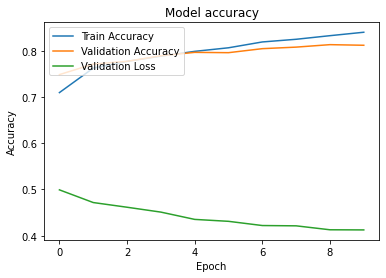

In [14]:
# training and validation accuracy plots by epoch

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy','Validation Loss'], loc='upper left')
plt.show()

In [15]:
df_test=pd.read_csv('data_4.csv')
df_test

,text,complexity
0,જો આપણે આત્માથી જીવીએ છીએ તો આત્માથી ચાલવું પણ...,1
1,ખ્રિસ્ત ઈસુ આપણા પ્રભુમાં તમારે વિષે મારું જે ...,1
2,"સ્‍ત્રીઓએ મંડળીઓમાં છાના રહેવું, કેમ કે તેઓને ...",1
3,કેમ કે હું માણસની પાસેથી તે પામ્યો નથી કે શીખ્...,1
4,પણ જેઓ લાગ શોધે છે તેઓને લાગ ન મળે તે માટે હું...,1
...,...,...
5357,சுருள் முடி கொண்ட ஆண் சமோசா சாப்பிடுகிறான். ...,0
5358,ஒரு ஆணும் குழந்தையும் மரத்தடியில் பாயில் கிடக்...,0
5359,பட விளக்கம்: ஒன்றன்பின் ஒன்றாக இரண்டு யானைகள் ...,0
5360,ராதா மண்ணில் கால் தடையங்களைக் கண்டு பயந்தாள். ...,0


In [16]:
#test data processing

test_x,test_y,_,_=train_val(df_test,0)

#prediction using test_data

test_pred = model.predict(test_x)

print("Predictions on Test data:")
test_pred[0:3]

168/168 [==============================] - 0s 593us/step
Predictions on Test data:


array([[0.46791923],
       [0.8825554 ],
       [0.5429306 ]], dtype=float32)

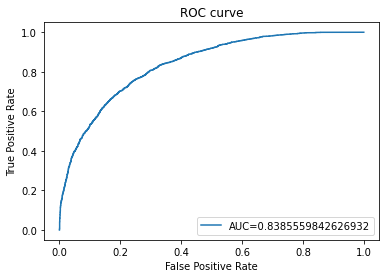

In [17]:
#create ROC curve
fpr, tpr, thresholds = metrics.roc_curve(test_y, test_pred)
auc = metrics.roc_auc_score(test_y, test_pred)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC curve")
plt.legend(loc=4)
plt.show()

In [18]:
# calculate optimal threshold from ROC statistics and get classification report
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print("Optimal threshold:",round(optimal_threshold,1))

Optimal threshold: 0.6


In [19]:
threshold_pred = (model.predict(test_x) > 0.6).astype(int)

print("Classification Report")
print(classification_report(test_y, threshold_pred))

168/168 [==============================] - 0s 582us/step
Classification Report
              precision    recall  f1-score   support

         0.0       0.76      0.74      0.75      2681
         1.0       0.75      0.77      0.76      2681

    accuracy                           0.75      5362
   macro avg       0.75      0.75      0.75      5362
weighted avg       0.75      0.75      0.75      5362



## Bengali Text

In [20]:
df_test=pd.read_csv('data.csv')
df_test

,text,complexity
0,সতত আনন্দ কর; অবিরত প্রার্থনা কর;,1
1,"অতএব “তোমরা তাহাদের মধ্য হইতে বাহির হইয়া আইস,...",1
2,"যেন এক্ষণে যথাকালে আপন ধার্ম্মিকতা দেখান, যেন ...",1
3,"কেননা তিনি এই সাক্ষ্য প্রাপ্ত হইতেছেন, “তুমিই ...",1
4,"কারণ তিনি মোশিকে বলেন, “আমি যাহাকে দয়া করি, ত...",1
...,...,...
995,তিনদিন হয়ে গেল সাঁকো মেরামত হল না । শোভনরা ...,0
996,গাছের মগডালে দোয়েল পাখির বাসা।,0
997,"কিন্তু বড় আনারস হেসে বলল, ""আমি অনেক বড়। কেউ ...",0
998,বীর বাঙালিরা তার ডাকে সাড়া দিলেন। ডাকে সাড়া ...,0


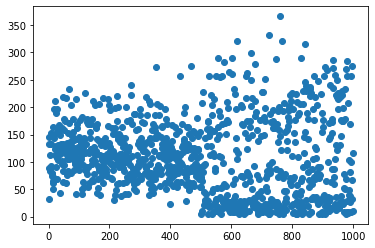

In [21]:
length=[len(i) for i in df_test.text.values]
import matplotlib.pyplot as plt
plt.scatter(df_test.index,length)

In [22]:
#test data processing

test_x,test_y,_,_=train_val(df_test,0)

#prediction using test_data

test_pred = model.predict(test_x)

print("Predictions on Test data:")
test_pred[0:3]

32/32 [==============================] - 0s 627us/step
Predictions on Test data:


array([[0.9548842 ],
       [0.98624015],
       [0.9756339 ]], dtype=float32)

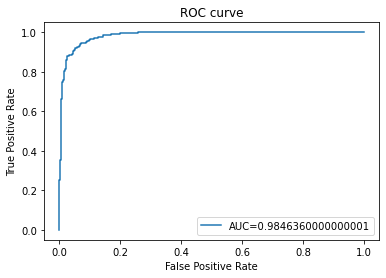

In [23]:
#create ROC curve
fpr, tpr, thresholds = metrics.roc_curve(test_y, test_pred)
auc = metrics.roc_auc_score(test_y, test_pred)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC curve")
plt.legend(loc=4)
plt.show()

In [24]:
# calculate optimal threshold from ROC statistics and get classification report
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print("Optimal threshold:",round(optimal_threshold,1))

Optimal threshold: 0.5


In [25]:
threshold_pred = (model.predict(test_x) > optimal_threshold).astype(int)

print("Classification Report")
print(classification_report(test_y, threshold_pred))

32/32 [==============================] - 0s 608us/step
Classification Report
              precision    recall  f1-score   support

         0.0       0.94      0.93      0.94       500
         1.0       0.93      0.94      0.94       500

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



## Hindi

In [26]:
df_test=pd.read_csv('data_3.csv')
df_test

,text,complexity
0,"ताकि जैसा लिखा है, वैसा ही हो, “जो घमण्ड करे व...",1
1,"परन्तु बात यह है : जो थोड़ा बोता है, वह थोड़ा ...",1
2,मैं ने अपनी पत्री में तुम्हें लिखा है कि व्यभि...,1
3,अपने बहुत से जातिवालों से जो मेरी अवस्था के थे...,1
4,परन्तु जो सन्देह कर के खाता है वह दण्ड के योग्...,1
...,...,...
995,यदि वहाँ व्याख्या करने वाला कोई न हो तो बोलने ...,0
996,मैंने कड़ा परिश्रम करके थकावट से चूर हो कर जीव...,0
997,"क्योंकि सुसमाचार में यह दर्शाया गया है, परमेश्...",0
998,"हे भाईयों, मैं तुम्हें जताना चाहता हूँ कि वह स...",0


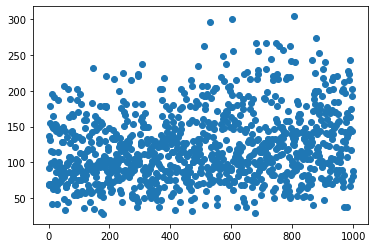

In [27]:
length=[len(i) for i in df_test.text.values]
import matplotlib.pyplot as plt
plt.scatter(df_test.index,length)

In [28]:
#test data processing

test_x,test_y,_,_=train_val(df_test,0)

#prediction using test_data

test_pred = model.predict(test_x)

print("Predictions on Test data:")
test_pred[0:3]

32/32 [==============================] - 0s 630us/step
Predictions on Test data:


array([[0.9676579],
       [0.9701823],
       [0.741006 ]], dtype=float32)

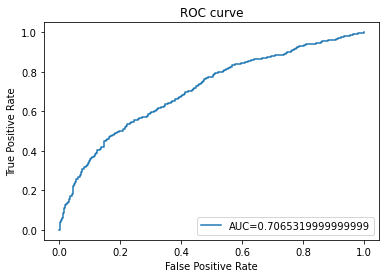

In [29]:
#create ROC curve
fpr, tpr, thresholds = metrics.roc_curve(test_y, test_pred)
auc = metrics.roc_auc_score(test_y, test_pred)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC curve")
plt.legend(loc=4)
plt.show()

In [30]:
# calculate optimal threshold from ROC statistics and get classification report
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print("Optimal threshold:",round(optimal_threshold,1))

Optimal threshold: 0.8


In [31]:
threshold_pred = (model.predict(test_x) > optimal_threshold).astype(int)

print("Classification Report")
print(classification_report(test_y, threshold_pred))

32/32 [==============================] - 0s 603us/step
Classification Report
              precision    recall  f1-score   support

         0.0       0.63      0.78      0.69       500
         1.0       0.71      0.53      0.61       500

    accuracy                           0.66      1000
   macro avg       0.67      0.66      0.65      1000
weighted avg       0.67      0.66      0.65      1000



## Urdu and Arabic

In [32]:
df_test=pd.read_csv('data_5.csv')
df_test

,text,complexity
0,یہ لگاتار مختلف جگہوں پر الاؤ جلا کر رکھتے ہیں,1
1,بہت سعی کے بعد آج بھی یہ قبیلے دنیا کے لئے ایک...,1
2,مجھے تو یہ گمان بھی نہ تھا کہ یہ آفت اس طرح ٹو...,1
3,چونکہ میں ایماندار تھی اور میرے دل میں کوئی کھ...,1
4,چند ہی دنوں میں انہیں افاقہ محسوس ہوا,1
...,...,...
1995,وهذا السِّرُّ هو: حِينَما يؤمِنُ النّاسُ مِن ك...,0
1996,فلا يَخدَعَنّكُم الّذينَ يُبَرِّرونَ هذِهِ الس...,0
1997,فاصمُدوا أحِبّائي في إيمانِكُم ولا تَتَزَحزَحو...,0
1998,إنّ لِلعامِلينَ عِندَ النّاسِ أُجرَةً، وهي حَق...,0


In [33]:
#test data processing

test_x,test_y,_,_=train_val(df_test,0)

#prediction using test_data

test_pred = model.predict(test_x)

print("Predictions on Test data:")
test_pred[0:3]

63/63 [==============================] - 0s 596us/step
Predictions on Test data:


array([[0.47292143],
       [0.2793408 ],
       [0.5099991 ]], dtype=float32)

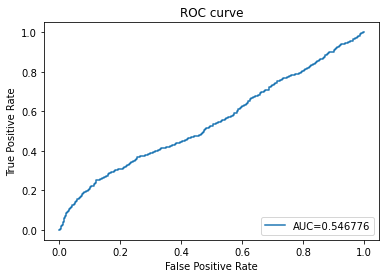

In [34]:
#create ROC curve
fpr, tpr, thresholds = metrics.roc_curve(test_y, test_pred)
auc = metrics.roc_auc_score(test_y, test_pred)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC curve")
plt.legend(loc=4)
plt.show()

In [35]:
# calculate optimal threshold from ROC statistics and get classification report
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print("Optimal threshold:",round(optimal_threshold,1))

Optimal threshold: 1.0


In [36]:
threshold_pred = (model.predict(test_x) > optimal_threshold).astype(int)

print("Classification Report")
print(classification_report(test_y, threshold_pred))

63/63 [==============================] - 0s 575us/step
Classification Report
              precision    recall  f1-score   support

         0.0       0.54      0.88      0.67      1000
         1.0       0.67      0.25      0.36      1000

    accuracy                           0.56      2000
   macro avg       0.61      0.56      0.52      2000
weighted avg       0.61      0.56      0.52      2000



## Tamil

In [37]:
df_test=pd.read_csv('data_6.csv')
df_test

,text,complexity
0,"ஏனெனில், இந்தக் கூடாரத்திலே நாம் தவித்து, நம்ம...",1
1,இப்படிப்பட்ட வாக்குத்தத்தங்கள் நமக்கு உண்டாயிர...,1
2,கிறிஸ்து இயேசுவினுடைய இரத்தத்தைப்பற்றும் விசுவ...,1
3,"இன்று அவருடைய சத்தத்தைக் கேட்பீர்களாகில், கோபம...",1
4,அவர் மோசேயை நோக்கி: எவன்மேல் இரக்கமாயிருக்கச் ...,1
...,...,...
219,சுருள் முடி கொண்ட ஆண் சமோசா சாப்பிடுகிறான். ...,0
220,ஒரு ஆணும் குழந்தையும் மரத்தடியில் பாயில் கிடக்...,0
221,பட விளக்கம்: ஒன்றன்பின் ஒன்றாக இரண்டு யானைகள் ...,0
222,ராதா மண்ணில் கால் தடையங்களைக் கண்டு பயந்தாள். ...,0


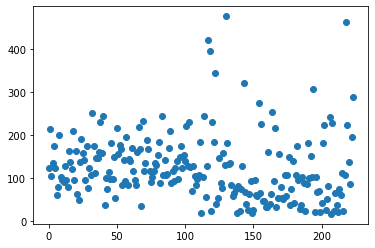

In [38]:
length=[len(i) for i in df_test.text.values]
import matplotlib.pyplot as plt
plt.scatter(df_test.index,length)

In [39]:
#test data processing

test_x,test_y,_,_=train_val(df_test,0)

#prediction using test_data

test_pred = model.predict(test_x)

print("Predictions on Test data:")
test_pred[0:3]

7/7 [==============================] - 0s 803us/step
Predictions on Test data:


array([[0.9767687 ],
       [0.96903515],
       [0.8055995 ]], dtype=float32)

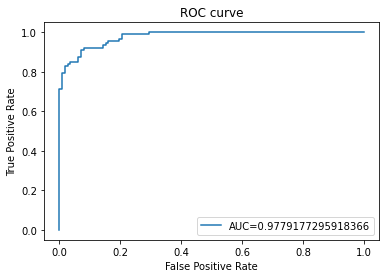

In [40]:
#create ROC curve
fpr, tpr, thresholds = metrics.roc_curve(test_y, test_pred)
auc = metrics.roc_auc_score(test_y, test_pred)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC curve")
plt.legend(loc=4)
plt.show()

In [41]:
# calculate optimal threshold from ROC statistics and get classification report
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print("Optimal threshold:",round(optimal_threshold,1))

Optimal threshold: 0.5


In [42]:
threshold_pred = (model.predict(test_x) > optimal_threshold).astype(int)

print("Classification Report")
print(classification_report(test_y, threshold_pred))

7/7 [==============================] - 0s 798us/step
Classification Report
              precision    recall  f1-score   support

         0.0       0.90      0.93      0.92       112
         1.0       0.93      0.90      0.91       112

    accuracy                           0.92       224
   macro avg       0.92      0.92      0.92       224
weighted avg       0.92      0.92      0.92       224



## Japanese

In [44]:
df_test=pd.read_csv('data_7.csv')
df_test

,text,complexity
0,お金を貸していただけませんか。,1
1,京都には一度行ったことがある。,1
2,手伝ってくれてどうもありがとう。,1
3,私は彼女に９時までに帰宅するように言った。,1
4,彼は昨日東京からやってきました。,1
...,...,...
995,誰も火に近づかないようにしろ。,0
996,彼の息子は８歳だ。,0
997,私は十分の間待ちました。,0
998,春には多くの美しい花が開く。,0


In [45]:
#test data processing

test_x,test_y,_,_=train_val(df_test,0)

#prediction using test_data

test_pred = model.predict(test_x)

print("Predictions on Test data:")
test_pred[0:3]

32/32 [==============================] - 0s 604us/step
Predictions on Test data:


array([[0.3873532 ],
       [0.06494265],
       [0.12786222]], dtype=float32)

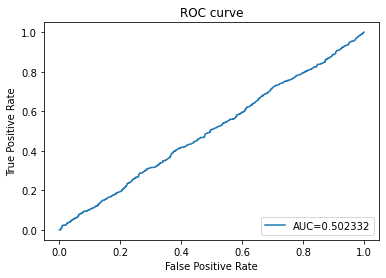

In [46]:
#create ROC curve
fpr, tpr, thresholds = metrics.roc_curve(test_y, test_pred)
auc = metrics.roc_auc_score(test_y, test_pred)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC curve")
plt.legend(loc=4)
plt.show()

In [47]:
# calculate optimal threshold from ROC statistics and get classification report
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print("Optimal threshold:",round(optimal_threshold,1))

Optimal threshold: 0.4


In [48]:
threshold_pred = (model.predict(test_x) > optimal_threshold).astype(int)

print("Classification Report")
print(classification_report(test_y, threshold_pred))

32/32 [==============================] - 0s 621us/step
Classification Report
              precision    recall  f1-score   support

         0.0       0.51      0.74      0.60       500
         1.0       0.52      0.29      0.37       500

    accuracy                           0.51      1000
   macro avg       0.51      0.51      0.48      1000
weighted avg       0.51      0.51      0.48      1000



## Mandarin

In [49]:
df_test=pd.read_csv('data_8.csv')
df_test

,text,complexity
0,我在你們那裏、又輭弱、又懼怕、又甚戰兢。,1
1,那賜種給撒種的、賜糧給人喫的、必多多加給你們種地的種子、又增添你們仁義的果子．,1
2,因爲審判教外的人與我何干．教內的人豈不是你們審判的麽．,1
3,因着信、連撒拉自己、雖然過了生育的歲數、還能懷孕．因他以爲那應許他的是可信的．,1
4,我們各人務要呌鄰舍喜悅、使他得益處、建立德行。,1
...,...,...
995,如果全身只有一个肢体，还会是身体吗？,0
996,主耶稣的父——永受称颂的上帝知道我不撒谎。,0
997,有关上帝的事情，可以让人类知道的都已经显而易见，因为上帝已经向人类显明了。,0
998,弟兄姊妹，你们的信心使我们在万般困苦和患难中得到了激励。,0


In [50]:
#test data processing

test_x,test_y,_,_=train_val(df_test,0)

#prediction using test_data

test_pred = model.predict(test_x)

print("Predictions on Test data:")
test_pred[0:3]

32/32 [==============================] - 0s 590us/step
Predictions on Test data:


array([[0.8810004 ],
       [0.98891956],
       [0.9976101 ]], dtype=float32)

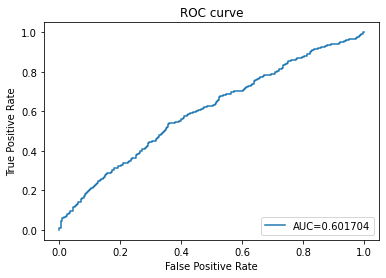

In [51]:
#create ROC curve
fpr, tpr, thresholds = metrics.roc_curve(test_y, test_pred)
auc = metrics.roc_auc_score(test_y, test_pred)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC curve")
plt.legend(loc=4)
plt.show()

In [52]:
# calculate optimal threshold from ROC statistics and get classification report
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print("Optimal threshold:",round(optimal_threshold,1))

Optimal threshold: 1.0


In [53]:
threshold_pred = (model.predict(test_x) > optimal_threshold).astype(int)

print("Classification Report")
print(classification_report(test_y, threshold_pred))

32/32 [==============================] - 0s 604us/step
Classification Report
              precision    recall  f1-score   support

         0.0       0.58      0.64      0.61       500
         1.0       0.60      0.54      0.57       500

    accuracy                           0.59      1000
   macro avg       0.59      0.59      0.59      1000
weighted avg       0.59      0.59      0.59      1000



## Korean

In [54]:
df_test=pd.read_csv('data_9.csv')

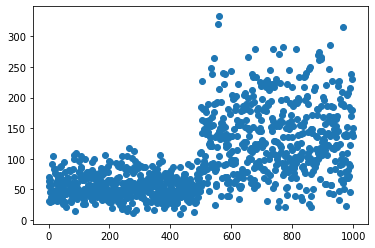

In [55]:
length=[len(i) for i in df_test.text.values]
import matplotlib.pyplot as plt
plt.scatter(df_test.index,length)

In [56]:
#test data processing

test_x,test_y,_,_=train_val(df_test,0)

#prediction using test_data

test_pred = model.predict(test_x)

print("Predictions on Test data:")
test_pred[0:3]

32/32 [==============================] - 0s 594us/step
Predictions on Test data:


array([[0.93488234],
       [0.98264587],
       [0.9934713 ]], dtype=float32)

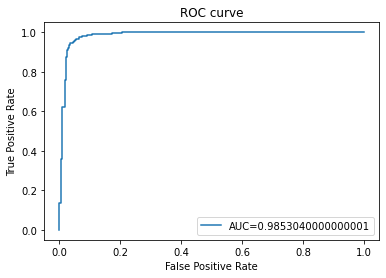

In [57]:
#create ROC curve
fpr, tpr, thresholds = metrics.roc_curve(test_y, test_pred)
auc = metrics.roc_auc_score(test_y, test_pred)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC curve")
plt.legend(loc=4)
plt.show()

In [58]:
# calculate optimal threshold from ROC statistics and get classification report
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print("Optimal threshold:",round(optimal_threshold,1))

Optimal threshold: 0.4


In [59]:
threshold_pred = (model.predict(test_x) > optimal_threshold).astype(int)

print("Classification Report")
print(classification_report(test_y, threshold_pred))

32/32 [==============================] - 0s 584us/step
Classification Report
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.95       500
         1.0       0.95      0.96      0.96       500

    accuracy                           0.95      1000
   macro avg       0.96      0.95      0.95      1000
weighted avg       0.96      0.95      0.95      1000

